# Segmentación de Clientes con Segmentación Manual

En este notebook se utiliza una base de datos de e-commerce para segmentar clientes de forma manual a partir de las métricas calculadas en el análisis:

- **Total Revenue**: Ingreso total por cliente.
- **Total Units**: Cantidad total de productos comprados.
- **NumCategories**: Número de categorías (diversidad de productos) compradas.

Además, se agrupa la variable numérica **age** con pd.cut para ver cómo se distribuyen las compras en función de grupos etarios.

El objetivo es definir segmentos (por ejemplo, "Bajo", "Medio" y "Alto" en Total Revenue) que sirvan para orientar estrategias de negocio, sin utilizar algoritmos de clustering complejos.

In [ ]:
!wget https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
!unzip customer_shopping_data.csv.zip

--2025-03-27 22:23:03--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip [following]
--2025-03-27 22:23:03--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1712272 (1.6M) [application/zip]
Saving to: ‘customer_shopping_data.csv.zip.2’

c

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
%matplotlib inline
sns.set(style='whitegrid')

## 1. Carga y Preprocesamiento de Datos

Utilizamos una base de datos sintética basada en la siguiente estructura:

- **invoice_no**
- **customer_id**
- **gender**
- **age**
- **category**
- **quantity**
- **price**
- **payment_method**
- **invoice_date**
- **shopping_mall**

Se convierte la fecha a datetime y se calcula la métrica *Revenue* (quantity * price).

In [ ]:
df = pd.read_csv('customer_shopping_data.csv')

In [ ]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')

df['Revenue'] = df['quantity'] * df['price']

print('Datos transaccionales:')
df

## 2. Análisis Exploratorio

Utilizamos pivot tables y crosstabs para explorar la distribución de ingresos y transacciones por diferentes dimensiones.

In [ ]:
pivot_sum1 = pd.pivot_table(
    df,
    index='category',
    values='Revenue',
    columns='gender',
    aggfunc='sum',
    fill_value=0)

print('Pivot Table - Suma de Ventas:')
print(pivot_sum1)

Pivot Table - Suma de Ventas:
gender                Female         Male
category                                 
Books              489314.70    345238.20
Clothing         68251695.60  45745095.44
Cosmetics         4066772.54   2726090.36
Food & Beverage    505322.60    344212.45
Shoes            39425167.30  27128284.17
Souvenir           382867.20    252957.45
Technology       34669950.00  23192400.00
Toys              2416046.08   1564380.16


In [ ]:
tabla_contingencia_totales = pd.crosstab(
    df['payment_method'],
    df['gender'],
    margins=True
)

print('Tabla de Contingencia con Totales:')
print(tabla_contingencia_totales)

Tabla de Contingencia con Totales:
gender          Female   Male    All
payment_method                      
Cash             26509  17938  44447
Credit Card      21011  13920  34931
Debit Card       11962   8117  20079
All              59482  39975  99457


## 3. Agregación a Nivel de Cliente

Agrupamos las transacciones por **customer_id** y **category** para obtener la cantidad total de cada producto comprado por cliente.

In [ ]:
df.groupby(['customer_id', 'category']).agg({'quantity': 'sum'}).sort_values('quantity', ascending=False)

,,quantity
customer_id,category,
C100004,Clothing,5
C100012,Food & Beverage,5
C291073,Souvenir,5
C291074,Cosmetics,5
C291003,Cosmetics,5
...,...,...
C999023,Clothing,1
C999000,Food & Beverage,1
C998999,Clothing,1


### Crear tabla a nivel de cliente (formato ancho)

Convertimos la tabla agrupada en un formato ancho: cada fila es un cliente y cada columna es una categoría. Esto facilita el análisis comparativo.

In [ ]:
pivot_sum2=pd.pivot_table(
    df,
    index='customer_id',
    columns='category',
    values='quantity',
    aggfunc='sum',
    fill_value=0)

print('Pivot Table - Suma de Ventas:')
(pivot_sum2)

Pivot Table - Suma de Ventas:


category,Books,Clothing,Cosmetics,Food & Beverage,Shoes,Souvenir,Technology,Toys
customer_id,,,,,,,,
C100004,0,5,0,0,0,0,0,0
C100005,0,0,0,0,2,0,0,0
C100006,0,0,0,0,0,0,0,3
C100012,0,0,0,5,0,0,0,0
C100019,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
C999886,0,0,0,3,0,0,0,0
C999910,3,0,0,0,0,0,0,0
C999974,0,5,0,0,0,0,0,0


## 4. Transformación con Melt: Formato Largo

Convertimos la tabla ancha a formato largo para obtener un DataFrame con tres columnas: `customer_id`, `category` y `quantity`. Este formato es útil para visualizar la distribución de compras por cliente.

In [ ]:
df_cantidad_largo = pd.melt(
    pivot_sum2.reset_index(),
    id_vars='customer_id',
    var_name='category',
    value_name='quantity')

print('Tabla de Ventas por Cliente en Formato Largo:')
(df_cantidad_largo)

Tabla de Ventas por Cliente en Formato Largo:


,customer_id,category,quantity
0,C100004,Books,0
1,C100005,Books,0
2,C100006,Books,0
3,C100012,Books,0
4,C100019,Books,0
...,...,...,...
795651,C999886,Toys,0
795652,C999910,Toys,0
795653,C999974,Toys,0
795654,C999976,Toys,3


## 5. Segmentación Manual usando pd.cut

Utilizaremos pd.cut para segmentar a los clientes en función de su **Total Revenue**. Definiremos 3 grupos:

- **Bajo**: Clientes con ingresos bajos.
- **Medio**: Clientes con ingresos moderados.
- **Alto**: Clientes con altos ingresos.

Calculamos las métricas a nivel de cliente y aplicamos pd.cut para crear la variable *RevenueSegment*.

Además, agrupamos la variable **age** en intervalos para ver la distribución de segmentos por grupo etario.

In [ ]:
df["Revenue_Segment"] = pd.cut(df["Revenue"],bins=3, labels=["Bajo", "Medio", "Alto"])
df

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Revenue,Age_Group,Revenue_Segment
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00,Joven,Bajo
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53,Joven,Bajo
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08,Joven,Bajo
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25,Mayor,Medio
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40,Mayor,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99452,I219422,C441542,Female,45,Souvenir,5,58.65,Credit Card,2022-09-21,Kanyon,293.25,Adulto,Bajo
99453,I325143,C569580,Male,27,Food & Beverage,2,10.46,Cash,2021-09-22,Forum Istanbul,20.92,Joven,Bajo
99454,I824010,C103292,Male,63,Food & Beverage,2,10.46,Debit Card,2021-03-28,Metrocity,20.92,Mayor,Bajo
99455,I702964,C800631,Male,56,Technology,4,4200.00,Cash,2021-03-16,Istinye Park,16800.00,Mayor,Medio


Además, agrupamos la edad en intervalos para complementar la segmentación.

In [ ]:
df["Age_Group"] = pd.cut(df["age"],bins=3, labels=["Joven", "Adulto", "Mayor"])
df

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Revenue,Age_Group,Revenue_Segment
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00,Joven,Bajo
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53,Joven,Bajo
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08,Joven,Bajo
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25,Mayor,Medio
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40,Mayor,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99452,I219422,C441542,Female,45,Souvenir,5,58.65,Credit Card,2022-09-21,Kanyon,293.25,Adulto,Bajo
99453,I325143,C569580,Male,27,Food & Beverage,2,10.46,Cash,2021-09-22,Forum Istanbul,20.92,Joven,Bajo
99454,I824010,C103292,Male,63,Food & Beverage,2,10.46,Debit Card,2021-03-28,Metrocity,20.92,Mayor,Bajo
99455,I702964,C800631,Male,56,Technology,4,4200.00,Cash,2021-03-16,Istinye Park,16800.00,Mayor,Medio


In [ ]:
tabla_contingencia = pd.crosstab(
    df['Age_Group'],
    df['Revenue_Segment']
)

print('Tabla de Contingencia:')
print(tabla_contingencia)

Tabla de Contingencia:
Revenue_Segment   Bajo  Medio  Alto
Age_Group                          
Joven            32028   2076   314
Adulto           30490   2036   350
Mayor            29893   1933   337


<Axes: xlabel='Revenue_Segment', ylabel='Age_Group'>

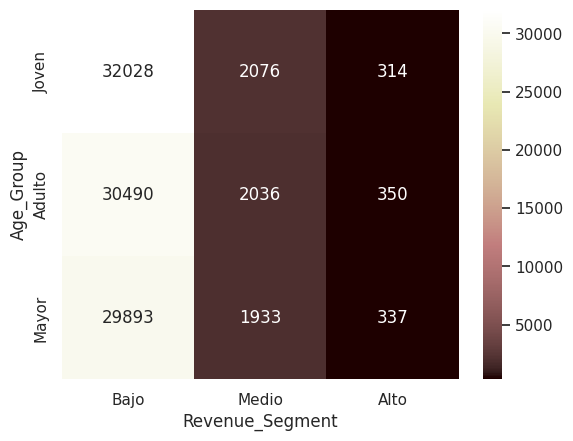

In [ ]:
import seaborn as sns

sns.heatmap(tabla_contingencia, annot=True, fmt="d", cmap="pink",
            xticklabels=tabla_contingencia.columns,
            yticklabels=tabla_contingencia.index)

## 6. Visualización Final de la Segmentación

Mostramos una gráfica de barras que resuma la cantidad de clientes en cada segmento de ingresos (*RevenueSegment*). Esta visualización permite identificar de forma rápida qué grupo es el predominante.

<ipython-input-112-eacd21b142d3>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_quantity = df.groupby("Revenue_Segment")["quantity"].sum()


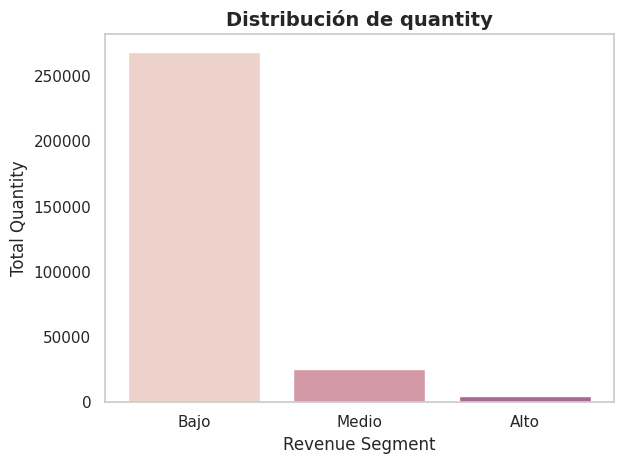

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
segment_quantity = df.groupby("Revenue_Segment")["quantity"].sum()

sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
plt.bar(segment_quantity.index, segment_quantity.values, color=sns.cubehelix_palette(n_colors=5))
plt.title('Distribución de quantity', fontsize=14, fontweight='bold')
plt.xlabel('Revenue Segment', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.xticks(rotation=0)
plt.grid(False)
plt.tight_layout()
plt.show()


## 7. Conclusiones y Siguientes Pasos

### Insights Obtenidos:

- La segmentación manual usando **pd.cut** permite clasificar a los clientes según su ingreso total, lo que puede ayudar a identificar clientes de alto valor para campañas de fidelización.
- La crosstab entre grupos de edad y segmentos de ingresos revela cómo varían los patrones de compra en función de la edad.

### Siguientes Pasos:

1. Profundizar en cada segmento analizando otros comportamientos (por ejemplo, diversidad de categorías y métodos de pago).
2. Diseñar estrategias de marketing específicas para cada segmento.
3. Integrar estos insights en dashboards interactivos para monitoreo en tiempo real.

Con este flujo de trabajo se demuestra cómo, sin necesidad de algoritmos avanzados, se puede segmentar a los clientes usando reglas definidas y herramientas de transformación de datos en **pandas**. ¡Éxito en tu análisis!